# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/emaminotti/ID2223-ScalableMLDL
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 11, 56, 23, 878461)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
# Connect to Hopsworks
try:
    import settings
    if settings.HOPSWORKS_API_KEY is not None:
        api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
        os.environ['HOPSWORKS_API_KEY'] = api_key
except ImportError:
    pass # Hopsworks will use cached key or prompt

project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

# Load the Multi-Sensor Configuration
secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
sensor_config = json.loads(location_str)

print(f"✅ Loaded configuration for {len(sensor_config)} sensors: {list(sensor_config.keys())}")

# Set global city/country
city = "Malmo"
country = "Sweden"

2025-11-17 11:56:23,891 INFO: Initializing external client
2025-11-17 11:56:23,891 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 11:56:24,555 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 11:56:25,258 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267872
✅ Loaded configuration for 2 sensors: ['radhuset', 'dalaplan']


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

# Get the Feature View
try:
    fv = fs.get_feature_view(name="air_quality_fv", version=2)
except:
    fv = fs.get_feature_view(name="air_quality", version=2) 

print("✅ Retrieved Model Registry and shared Feature View.")

✅ Retrieved Model Registry and shared Feature View.


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [6]:
from datetime import datetime, timezone
import pandas as pd

# Get today's date (UTC)
today = datetime.now(timezone.utc).date()
print(f"Fetching batch data for all sensors starting from: {today}...")

# Get all available batch data (including future weather)
try:
    batch_data = fv.get_batch_data()
except Exception as e:
    print(f"Error: {e}. Ensure Feature View '{fv.name}' (v{fv.version}) exists.")

# Filter data: Keep only rows for today or in the future
batch_data['date'] = pd.to_datetime(batch_data['date'])
batch_data = batch_data[batch_data['date'].dt.date >= today].copy()

# Sort for clarity
batch_data = batch_data.sort_values(by=['street', 'date'])

print(f"✅ Found {len(batch_data)} feature rows (for {batch_data['street'].nunique()} sensors) spanning {batch_data['date'].nunique()} future days.")
display(batch_data.head())

Fetching batch data for all sensors starting from: 2025-11-17...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 
✅ Found 2 feature rows (for 2 sensors) spanning 1 future days.


,street,date,pm25_lag_1,pm25_lag_2,pm25_lag_3,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,weather_city
1180,dalaplan,2025-11-17 00:00:00+00:00,15.0,13.0,12.0,4.4,0.5,21.9,318.0,78.0,malmo
1179,radhuset,2025-11-17 00:00:00+00:00,13.0,15.0,10.0,4.4,0.5,21.9,318.0,78.0,malmo


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [7]:
import joblib
import shutil
import os
import pandas as pd

# Get the model registry
mr = project.get_model_registry()

# --- THE FIX ---
# We will now define the 'features' list to match the "Data Provided"
# part of the error message (List 1).
features = [
    "pm25_lag_1", "pm25_lag_2", "pm25_lag_3", 
    "weather_temperature_2m_mean", 
    "weather_precipitation_sum", 
    "weather_wind_speed_10m_max", 
    "weather_wind_direction_10m_dominant", # <-- List 1 order
    "weather_humidity_mean"                # <-- List 1 order
]
# ---

predictions_list = []

# Loop through each sensor in your configuration
for sensor_name, config in sensor_config.items():
    street_name = config['street']
    print(f"🚀 Generating prediction for: {sensor_name} ({street_name})")
    
    # 1. Filter the batch_data for this specific street
    sensor_data = batch_data[batch_data['street'] == street_name].copy()
    
    if len(sensor_data) == 0:
        print(f"   - No batch data found for {street_name} today. Skipping.")
        continue

    try:
        # 2. Download the correct model for this sensor
        model_name = f"air_quality_xgboost_{street_name}"
        retrieved_model = mr.get_model(name=model_name, version=None) # Get latest version
        saved_model_dir = retrieved_model.download()

        # 3. Load the model
        model_path = os.path.join(saved_model_dir, "model.pkl")
        xgb_model = joblib.load(model_path)
        
        # 4. Prepare the feature vector (X)
        # Fill NaNs with 0 and select features in the (hopefully) correct order
        X_inference = sensor_data[features].fillna(0)
        
        # 5. Make the prediction
        predictions = xgb_model.predict(X_inference)
        sensor_data['predicted_pm25'] = predictions
        
        # 6. Store the result
        predictions_list.append(sensor_data)
        
        # 7. Clean up the downloaded model directory
        shutil.rmtree(saved_model_dir)
        print(f"   - Prediction: {predictions[0]:.2f}")

    except Exception as e:
        print(f"   - ⚠️ Error processing {sensor_name}: {e}")


# 8. Combine all predictions into one DataFrame
if predictions_list:
    final_predictions_df = pd.concat(predictions_list).sort_values(by='street')
    print("\n✅ All predictions generated successfully.")
    display(final_predictions_df)
else:
    print("\nNo predictions were generated.")

🚀 Generating prediction for: radhuset (radhuset)
2025-11-17 11:56:34,602 WARNING: VersionWarning: No version provided for getting model `air_quality_xgboost_radhuset`, defaulting to `1`.



Downloading: 0.000%|          | 0/2389182 elapsed<00:00 remaining<?

   - Prediction: 10.43fact (0 dirs, 1 files)... DONE
🚀 Generating prediction for: dalaplan (dalaplan)
2025-11-17 11:56:36,873 WARNING: VersionWarning: No version provided for getting model `air_quality_xgboost_dalaplan`, defaulting to `1`.



Downloading: 0.000%|          | 0/2384964 elapsed<00:00 remaining<?

   - Prediction: 11.88fact (0 dirs, 1 files)... DONE

✅ All predictions generated successfully.


,street,date,pm25_lag_1,pm25_lag_2,pm25_lag_3,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,weather_city,predicted_pm25
1180,dalaplan,2025-11-17 00:00:00+00:00,15.0,13.0,12.0,4.4,0.5,21.9,318.0,78.0,malmo,11.883596
1179,radhuset,2025-11-17 00:00:00+00:00,13.0,15.0,10.0,4.4,0.5,21.9,318.0,78.0,malmo,10.425151


In [8]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 1180 to 1179
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   street                               2 non-null      object                 
 1   date                                 2 non-null      datetime64[us, Etc/UTC]
 2   pm25_lag_1                           2 non-null      float32                
 3   pm25_lag_2                           2 non-null      float32                
 4   pm25_lag_3                           2 non-null      float32                
 5   weather_temperature_2m_mean          2 non-null      float64                
 6   weather_precipitation_sum            2 non-null      float64                
 7   weather_wind_speed_10m_max           2 non-null      float64                
 8   weather_wind_direction_10m_dominant  2 non-null      float64             

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [9]:
print("✅ Predictions ready for all sensors.")
display(final_predictions_df)

✅ Predictions ready for all sensors.


,street,date,pm25_lag_1,pm25_lag_2,pm25_lag_3,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,weather_city,predicted_pm25
1180,dalaplan,2025-11-17 00:00:00+00:00,15.0,13.0,12.0,4.4,0.5,21.9,318.0,78.0,malmo,11.883596
1179,radhuset,2025-11-17 00:00:00+00:00,13.0,15.0,10.0,4.4,0.5,21.9,318.0,78.0,malmo,10.425151


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 1180 to 1179
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   street                               2 non-null      object                 
 1   date                                 2 non-null      datetime64[us, Etc/UTC]
 2   pm25_lag_1                           2 non-null      float32                
 3   pm25_lag_2                           2 non-null      float32                
 4   pm25_lag_3                           2 non-null      float32                
 5   weather_temperature_2m_mean          2 non-null      float64                
 6   weather_precipitation_sum            2 non-null      float64                
 7   weather_wind_speed_10m_max           2 non-null      float64                
 8   weather_wind_direction_10m_dominant  2 non-null      float64             

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

📸 Generating forecast plots for all sensors...


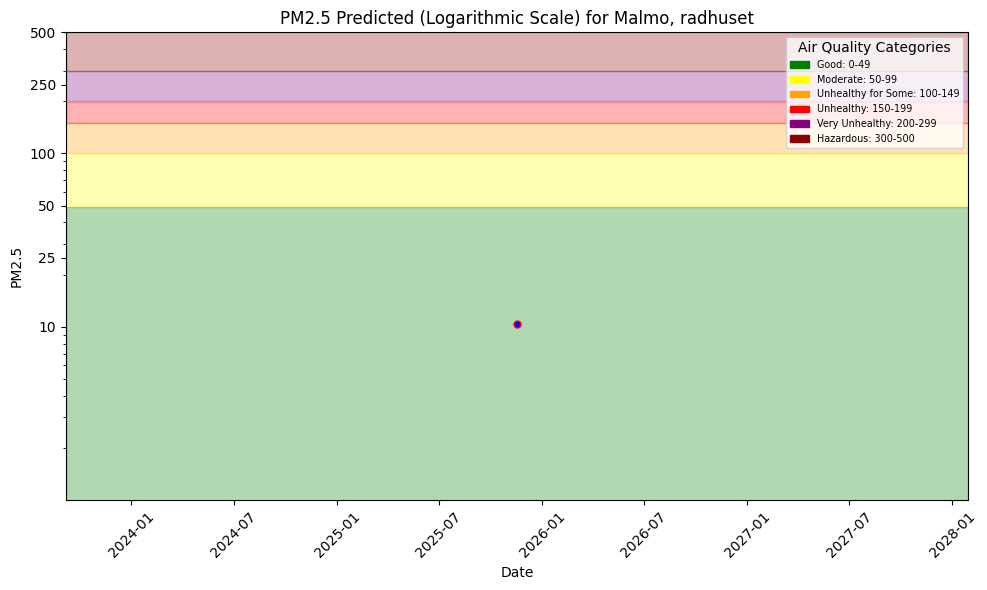

   - Saved plot: forecast_images/pm25_forecast_radhuset.png


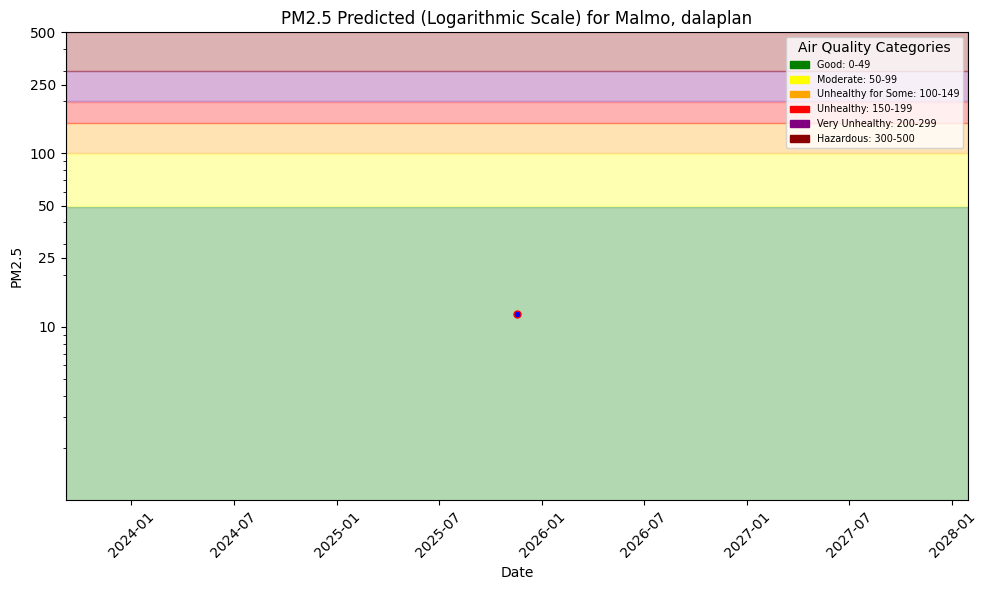

   - Saved plot: forecast_images/pm25_forecast_dalaplan.png

✅ All forecast plots generated.


In [12]:
import os
import matplotlib.pyplot as plt

# 1. Create a directory for the forecast images
images_dir = "forecast_images"
os.makedirs(images_dir, exist_ok=True)

print("📸 Generating forecast plots for all sensors...")

# 2. Loop through each sensor in your config
for sensor_name, config in sensor_config.items():
    street_name = config['street']
    
    # 3. Filter the main predictions DataFrame for this sensor
    sensor_predictions = final_predictions_df[
        final_predictions_df['street'] == street_name
    ]
    
    if len(sensor_predictions) == 0:
        print(f"   - No predictions found for {street_name}. Skipping plot.")
        continue
    
    try:
        # 4. Define a unique file path for this sensor's plot
        pred_file_path = os.path.join(images_dir, f"pm25_forecast_{street_name}.png")
        
        # 5. Plot the forecast for this sensor
        # (Assuming 'util' is imported)
        util.plot_air_quality_forecast(
            city, 
            street_name,
            sensor_predictions, 
            pred_file_path
        )
        
        plt.show() 
        
        print(f"   - Saved plot: {pred_file_path}")

    except Exception as e:
        print(f"   - ⚠️ Error plotting for {sensor_name}: {e}")

print("\n✅ All forecast plots generated.")

In [23]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [24]:
cols_to_drop = [
    'pm25_lag_1', 
    'pm25_lag_2', 
    'pm25_lag_3',
    'air_quality_dalaplan_date', 
    'air_quality_dalaplan_pm25', 
    'air_quality_dalaplan_street', 
    'air_quality_dalaplan_country', 
    'air_quality_dalaplan_url'
]

batch_data = batch_data.drop(columns=[c for c in cols_to_drop if c in batch_data.columns])

batch_data = batch_data.rename(columns={
    "weather_temperature_2m_mean": "temperature_2m_mean",
    "weather_precipitation_sum": "precipitation_sum",
    "weather_wind_speed_10m_max": "wind_speed_10m_max",
    "weather_wind_direction_10m_dominant": "wind_direction_10m_dominant"
})

monitor_fg.insert(batch_data, wait=True)

FeatureStoreException: Features are not compatible with Feature Group schema: 
 - temperature_2m_mean (expected type: 'float', derived from input: 'double') has the wrong type.
 - precipitation_sum (expected type: 'float', derived from input: 'double') has the wrong type.
 - wind_speed_10m_max (expected type: 'float', derived from input: 'double') has the wrong type.
 - wind_direction_10m_dominant (expected type: 'float', derived from input: 'double') has the wrong type.
 - city (type: 'string') is missing from input dataframe.
 - predicted_pm25 (type: 'float') is missing from input dataframe.
 - country (type: 'string') is missing from input dataframe.
 - days_before_forecast_day (type: 'bigint') is missing from input dataframe.
 - weather_humidity_mean (type: 'double') does not exist in feature group.
 - weather_city (type: 'string') does not exist in feature group.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.

In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-07 00:00:00+00:00,9.600000,0.0,14.241629,163.855591,malmo,60.268311,radhuset,sweden,1
1,2025-11-03 00:00:00+00:00,9.275666,3.0,25.975565,215.782288,malmo,28.064899,radhuset,sweden,1
2,2025-11-04 00:00:00+00:00,12.127749,1.1,23.828764,216.520386,malmo,34.896755,radhuset,sweden,1
3,2025-11-06 00:00:00+00:00,11.550000,0.0,14.512064,150.255203,malmo,33.692642,radhuset,sweden,1
4,2025-11-05 00:00:00+00:00,11.313167,0.1,17.548845,187.334595,malmo,35.320026,radhuset,sweden,1
5,2025-11-09 00:00:00+00:00,8.950000,0.0,6.369050,227.290634,malmo,29.786793,radhuset,sweden,1
6,2025-11-11 00:00:00+00:00,13.850000,0.2,22.253124,170.690140,malmo,33.199680,radhuset,sweden,1
7,2025-11-12 00:00:00+00:00,9.900000,0.0,20.880001,180.000000,malmo,51.256287,dalaplan,sweden,1
8,2025-11-13 00:00:00+00:00,12.450000,0.0,28.357855,236.915131,malmo,24.323013,dalaplan,sweden,1


In [ ]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,pm25,country,city,street,url
0,2018-11-24 00:00:00+00:00,53.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866
1,2020-09-22 00:00:00+00:00,67.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866
2,2023-02-21 00:00:00+00:00,38.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866
3,2019-04-10 00:00:00+00:00,26.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866
4,2024-11-23 00:00:00+00:00,17.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866
...,...,...,...,...,...,...
2848,2023-02-08 00:00:00+00:00,63.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866
2849,2025-11-07 00:00:00+00:00,74.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866
2850,2025-11-08 00:00:00+00:00,71.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866
2851,2025-11-09 00:00:00+00:00,70.0,sweden,malmo,radhuset,https://api.waqi.info/feed/@7866


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2025-11-03 00:00:00+00:00,28.064899,35.0
2,2025-11-04 00:00:00+00:00,34.896755,36.0
4,2025-11-05 00:00:00+00:00,35.320026,22.0
3,2025-11-06 00:00:00+00:00,33.692642,26.0
0,2025-11-07 00:00:00+00:00,60.268311,74.0
5,2025-11-09 00:00:00+00:00,29.786793,70.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

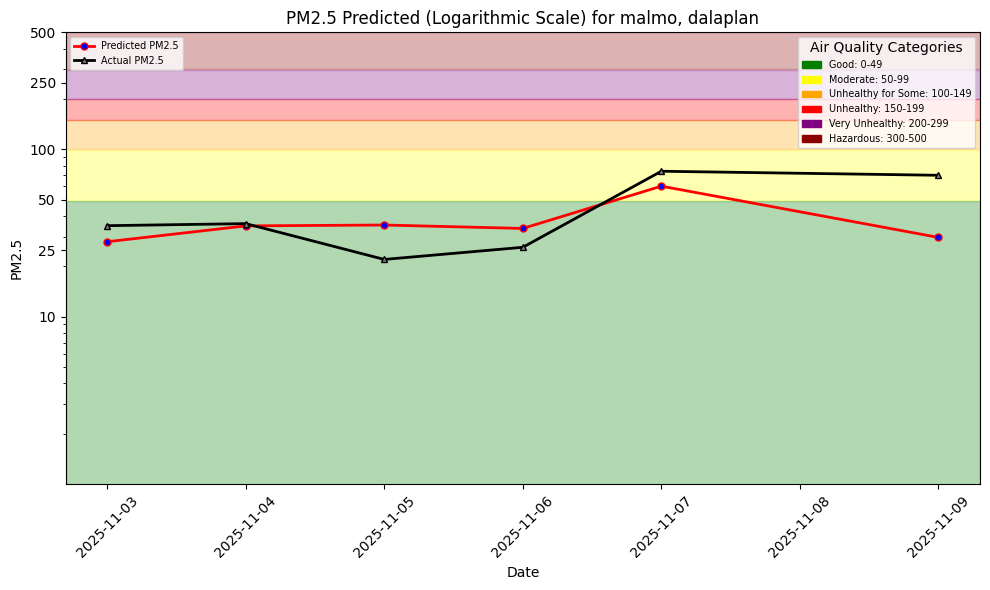

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{street}.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/emaminotti/ID2223-ScalableMLDL/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|        …

Uploading /Users/emaminotti/ID2223-ScalableMLDL/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|   …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1267872/settings/fb/path/Resources/airquality


---